In [1]:
import numpy as np
import os
import scipy.io
import h5py
import matplotlib.pyplot as plt
from scipy.signal import hilbert, chirp
from scipy import signal
import importlib
from pathlib import Path
import scipy.stats as st
import astropy.stats 
import pandas as pd
import random
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster import hierarchy
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import PGanalysis
import phase_analysis
import odor_phase_analysis

## This notebook contains code to generate Figure 5

In [2]:
# load the data 
shiva_data = np.load(r'C:\Users\rmb55\most_updated_pattern_stim\pattern_stim_analysis\odor_analysis\shiva_odor_responses.npy', allow_pickle = True)[0]

### First, let's plot some example phase-warped odor responses

In [3]:
# get the concatenated, phase-warped psths and rasters
phase_warped_PSTHs_expt = shiva_data['phase_warped_PSTHs_expt']
phase_warped_PSTHs_expt_cat = np.array([expt for expts in phase_warped_PSTHs_expt for expt in expts])
phase_aligned_rasters_cat = [expt for expts in shiva_data['phase_aligned_rasters_expt'] for expt in expts]

In [75]:
n_cells = []
for expt in phase_warped_PSTHs_expt:
    n_cells.append(expt.shape[0])
    
print('mean cells per experiment = ' + str(np.mean(n_cells)))
CI = st.t.interval(alpha=0.95, df=len(n_cells)-1, loc=np.mean(n_cells), scale=st.sem(n_cells)) 
print('95% confidence interval = ' + str(np.mean(n_cells)-CI[0]))

mean cells per experiment = 52.5
95% confidence interval = 8.688544118329268


meta NOT subset; don't know how to subset; dropped


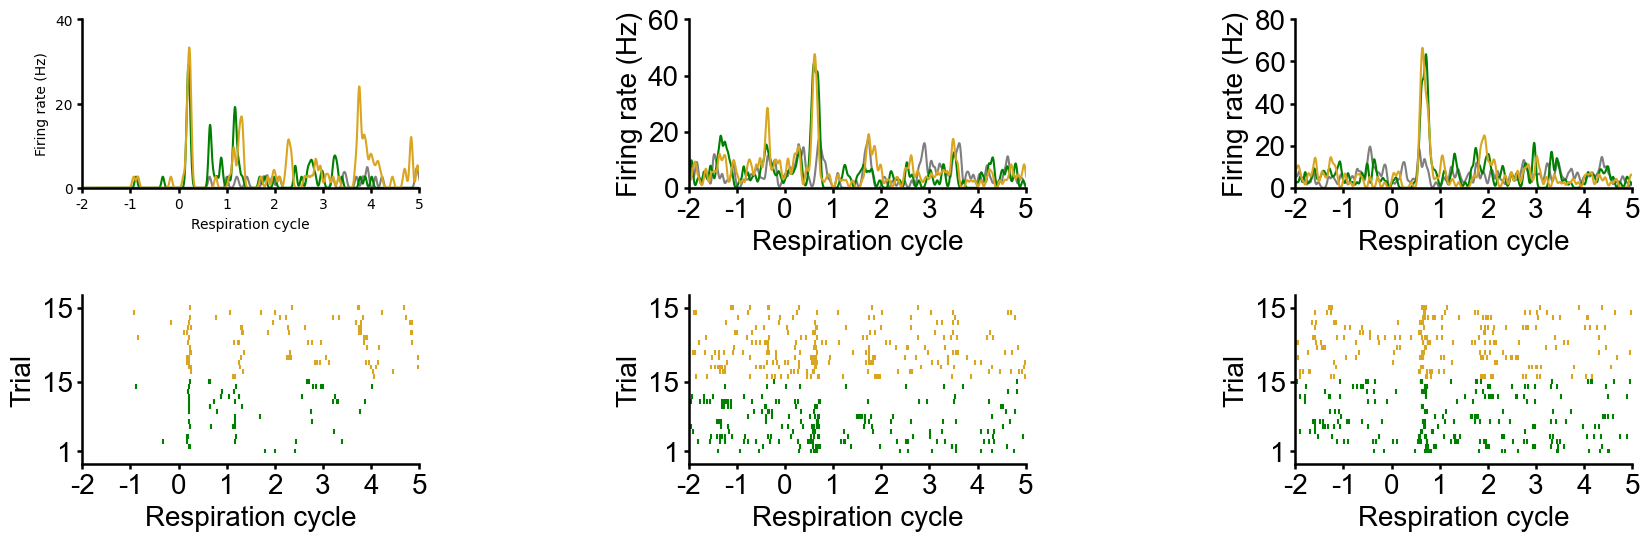

In [4]:
# plot psths and rasters in response to two odorants for some example cells 
x_warp = np.arange(-60,60,.05)
cell_IDs = [36,28,59]
y_scale = [40,60,80]
plt.figure(figsize = (20,6))
for cell_n, cell_ID in enumerate(cell_IDs):
    
    plt.subplot(2,3,cell_n+1)
    colors = ['k','r','m','c','g','orchid','olive', 'coral', 'lightblue', 'lightgreen', 'goldenrod']
    plt.plot(x_warp, np.mean(phase_warped_PSTHs_expt_cat[cell_ID,0,:,:],0), color = colors[0], alpha = .5)
    plt.plot(x_warp, np.mean(phase_warped_PSTHs_expt_cat[cell_ID,4,:,:],0), color = colors[4])
    plt.plot(x_warp, np.mean(phase_warped_PSTHs_expt_cat[cell_ID,10,:,:],0), color = colors[10])
    plt.xticks(np.arange(-6.28*5,6.28*6,6.28), labels = ['-5','-4','-3','-2','-1','0','1','2','3','4','5'])
    plt.xlim(-6.28*2, 6.28*5)
    plt.ylim(0,y_scale[cell_n])
    plt.yticks(np.arange(0, y_scale[cell_n]+20, 20))
    plt.xlabel('Respiration cycle')
    plt.ylabel('Firing rate (Hz)')
    PGanalysis.axis_fixer(ratio = .5, size = 20)

    plt.subplot(2,3,cell_n+4)
    i = 0
    odors = [4,10]
    for odor_n, odor in enumerate(odors):
        for trial in np.arange(phase_warped_PSTHs_expt_cat.shape[2]):
            if odor_n == 0:
                plt.eventplot(phase_aligned_rasters_cat[cell_ID][odor][trial], lineoffsets = i, color = 'g')
            else:
                plt.eventplot(phase_aligned_rasters_cat[cell_ID][odor][trial], lineoffsets = i, color = 'goldenrod')
            i+=1
    plt.xlim(-6.28*2, 6.28*5)
    plt.yticks([0,14,29], labels = ['1','15','15'])
    plt.ylabel('Trial')
    plt.xlabel('Respiration cycle')
    plt.xticks(np.arange(-6.28*2,6.28*6,6.28), labels = ['-2','-1','0','1','2','3','4','5'])
    PGanalysis.axis_fixer(ratio = .5, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\example_cells.pdf', bbox_inches = 'tight')

### Next, we will plot a matrix of similarity values (euclidean distance) between PSTHs for these example cells

In [5]:
# get the trial mean psths for all cells
phase_warped_PSTHs_expt_mean = np.mean(phase_warped_PSTHs_expt_cat,2)
# define an analysis window of one full respiration cycle
analyze_resp = np.where((x_warp>0) & (x_warp<np.radians(360)))[0]

In [6]:
cells = [36,28,59]
odor1 = 4
odor2 = 10
phase_warped_PSTHs_expt_mean_analyze = phase_warped_PSTHs_expt_mean[:,:,analyze_resp]

distance_mat = np.empty((len(cells),len(cells)))
for cell_n1, cell1 in enumerate(cells):
    for cell_n2, cell2 in enumerate(cells):
        cell1_norm_odor1 = phase_warped_PSTHs_expt_mean_analyze[cell1,odor1,:]/np.max(phase_warped_PSTHs_expt_mean_analyze[cell1,odor1,:])
        cell1_norm_odor2 = phase_warped_PSTHs_expt_mean_analyze[cell2,odor2,:]/np.max(phase_warped_PSTHs_expt_mean_analyze[cell2,odor2,:])
        self_distance = np.linalg.norm((cell1_norm_odor1-cell1_norm_odor2))
        distance_mat[cell_n1, cell_n2] = self_distance

meta NOT subset; don't know how to subset; dropped


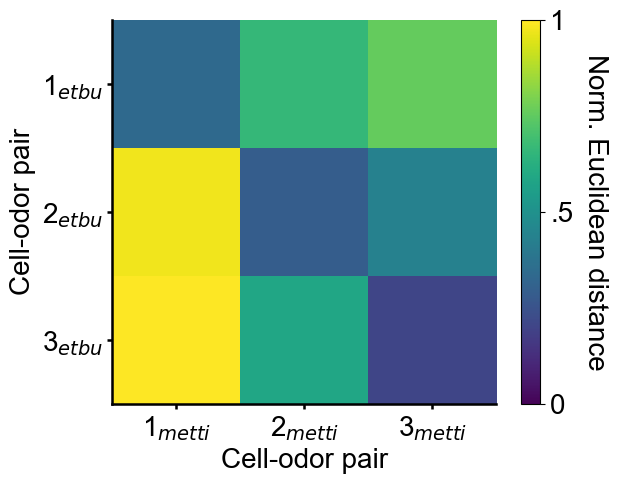

In [7]:
plt.imshow(distance_mat/np.max(distance_mat))
plt.xticks([0,1,2], labels = ['1$_{metti}$', '2$_{metti}$', '3$_{metti}$'])
plt.xlabel('Cell-odor pair')
plt.yticks([0,1,2], labels = ['1$_{etbu}$', '2$_{etbu}$', '3$_{etbu}$'])
plt.ylabel('Cell-odor pair')
plt.clim(0,1)

ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.5,1])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Norm. Euclidean distance', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\example_cell_response_eucdist.pdf', bbox_inches = 'tight')

### Let's plot all cells sorted by latency to peak for the same odor pair (etbu and metti)

### First, identify significantly odor activated cells

In [8]:
phase_aligned_rasters_expt = shiva_data['phase_aligned_rasters_expt']
n_total_cells = len(phase_aligned_rasters_cat)
n_odors = len(phase_aligned_rasters_cat[0])
n_trials = len(phase_aligned_rasters_cat[0][0])
### Initialize array to count the number of spikes occuring in the first respiration cycle for each trial
spike_count_first_breath_cycle = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(phase_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                n_spikes = 0
                for spike in trial:
                    # sum the number of spikes occuring in the first full cycle for each cell for each odor trial
                    if ((spike > 0) & (spike <  np.radians(360))):
                        n_spikes+=1
                spike_count_first_breath_cycle[cell_counter, n_odor, n_trial] = n_spikes
        cell_counter+=1

In [9]:
cells_activated = np.zeros((n_total_cells,n_odors))
cells_suppressed = np.zeros((n_total_cells,n_odors))
p_vals_all = np.zeros((n_total_cells,n_odors))
# loop through odors 
for odor_num in range(n_odors):
    # get the number of spikes for the selected odor 
    p1 = spike_count_first_breath_cycle[:,odor_num, :]
    # get the number of spikes in response to mineral oil 
    p2 = spike_count_first_breath_cycle[:,0,:]
    # perform a significance test to find significantly activated and suppressed cells
    pvals,auroc = PGanalysis.twoptn_rank_sum_test(p1,p2)
    p_vals_all[:, odor_num] = pvals
    cells_activated[(np.where((pvals<.01) & (auroc>.5))[0]), odor_num] = 1
    cells_suppressed[(np.where((pvals<.01) & (auroc<.5))[0]), odor_num] = 1

### Next, plot the responses of these cells to etbu and metti, sorted by etbu response latencies

In [10]:
odor1 = 4
odor2 = 10

# identify cells significantly activated by both odorants 
multi_tuned_idx = np.where(np.sum(cells_activated[:,[odor1,odor2]],1)>1)[0]
analyze_period_odor1 = phase_warped_PSTHs_expt_mean_analyze[multi_tuned_idx,odor1,:]
analyze_period_odor2 = phase_warped_PSTHs_expt_mean_analyze[multi_tuned_idx,odor2,:]
plot_indices_odor1 = np.argsort(np.argmax(analyze_period_odor1, axis = 1),0)

meta NOT subset; don't know how to subset; dropped


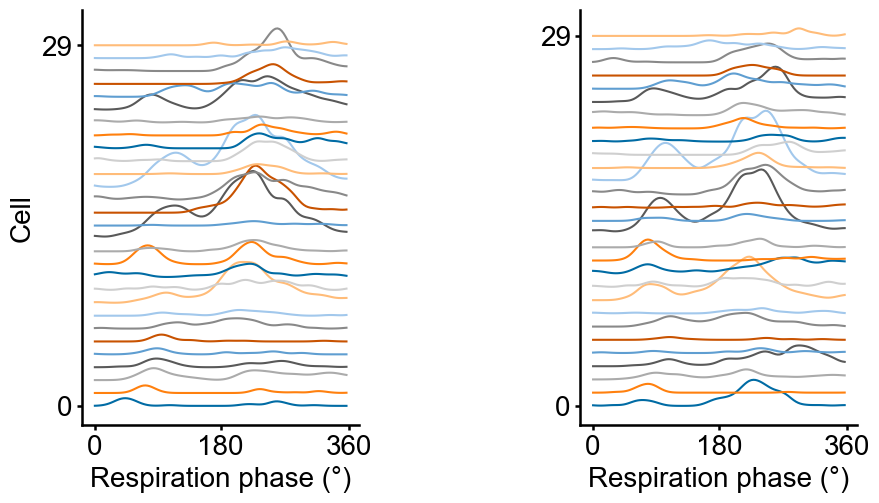

In [11]:
# get the colors to use for plotting 
plt.style.use("tableau-colorblind10")
cycler = plt.rcParams['axes.prop_cycle']

plt.figure(figsize = (10,10))
plt.subplot(1,2,1)
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = cycler
for cell_n, cell in enumerate(plot_indices_odor1):
    plt.plot(analyze_period_odor1[cell,:] + 50*cell_n)
plt.yticks([0,50*cell_n], labels = ['0',str(len(plot_indices_odor1))])
plt.xticks([0,62,125], labels = [0, 180, 360])
plt.ylabel('Cell')
plt.xlabel('Respiration phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 20)

plt.subplot(1,2,2)
plt.style.use('default')
plt.rcParams['axes.prop_cycle'] = cycler
for cell_n, cell in enumerate(plot_indices_odor1):
    plt.plot(analyze_period_odor2[cell,:] + 50*cell_n)
plt.yticks([0,50*cell_n], labels = ['0',str(len(plot_indices_odor1))])
plt.xticks([0,62,125], labels = [0, 180, 360])
plt.xlabel('Respiration phase (°)')
PGanalysis.axis_fixer(ratio = 1.5, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\etbu_metti_sequences.pdf', bbox_inches = 'tight')

### Now, for each cell, we want to know how similar the cell's response profile (timing) is across odorants. To measure this, we will compute the euclidean distance between each cell's response to all significantly activating odors, and compare this to every other cell's response profile.

In [12]:
off_diag_mat = []
off_diag_mat_pair = []
diag_mat = []
# loop through pairs of odors, excluding mineral oil control and self-comparisons
for odor1 in range(1,n_odors):
    for odor2 in range(1,n_odors):
        if odor1 != odor2:
            # find the cells signficantly activated by both odors in the pair
            multi_tuned_idx = np.where(np.sum(cells_activated[:,[odor1,odor2]],1)>1)[0]
            phase_warped_PSTHs_expt_mean_analyze = phase_warped_PSTHs_expt_mean[:,:,analyze_resp]

            # Initialize a distance matrix, which will be shape n_cells x n_cells and contain the euclidean distance calculated between odor-evoked PSTHs for each cell pair for the given odor pair.
            distance_mat = np.empty((len(multi_tuned_idx),len(multi_tuned_idx)))
            for cell_n1, cell1 in enumerate(multi_tuned_idx):
                for cell_n2, cell2 in enumerate(multi_tuned_idx):
                    # compute the euclidean distance between each cell's normalized response to odor 1 and to odor 2. The diagonals of the matrix are within-cell comparisons of responses to odor1 and odor 2. Outside of the diagonal are between-cell comparisons. 
                    cell1_norm_odor1 = phase_warped_PSTHs_expt_mean_analyze[cell1,odor1,:]/np.max(phase_warped_PSTHs_expt_mean_analyze[cell1,odor1,:])
                    cell1_norm_odor2 = phase_warped_PSTHs_expt_mean_analyze[cell2,odor2,:]/np.max(phase_warped_PSTHs_expt_mean_analyze[cell2,odor2,:])
                    psth_distance = np.linalg.norm((cell1_norm_odor1-cell1_norm_odor2))
                    distance_mat[cell_n1, cell_n2] = psth_distance
            
            # create a list of diagonal and off-diagonals in the matrix to compare within cell response distances to between cell response distances. 
            off_diag_mat = []
            for x in range(distance_mat.shape[0]):
                for y in range(distance_mat.shape[1]):
                    if x != y:
                        off_diag_mat.append(distance_mat[x,y])
            off_diag_mat_pair.append(off_diag_mat)
            diag_mat.append(np.diag(distance_mat))

In [13]:
# for each odor pair, get the mean with cell distance and across cell distance
diag_mat_flat_means = [np.mean(pair) for pair in diag_mat]
off_diag_mat_flat_means = [np.mean(pair) for pair in off_diag_mat_pair]

In [14]:
# Calculate the 95% confidence interval of the mean for within cell and across-cell distances 
CI_diag = st.t.interval(alpha=0.95, df=len(diag_mat_flat_means)-1, loc=np.mean(diag_mat_flat_means), scale=st.sem(diag_mat_flat_means)) 
CI_off_diag = st.t.interval(alpha=0.95, df=len(off_diag_mat_flat_means)-1, loc=np.mean(off_diag_mat_flat_means), scale=st.sem(off_diag_mat_flat_means)) 

meta NOT subset; don't know how to subset; dropped


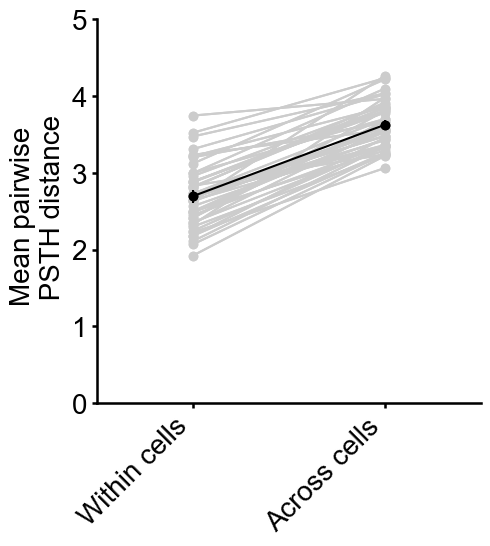

In [15]:
# plot within vs. across cell distances for all odor pairs 
for pair in range(len(diag_mat_flat_means)):
    plt.plot([1,2],[diag_mat_flat_means[pair],off_diag_mat_flat_means[pair]],'-o', color = [.8,.8,.8])
plt.plot([1,2], [np.mean(diag_mat_flat_means), np.mean(off_diag_mat_flat_means)], '-ko')
plt.errorbar(1, np.mean(diag_mat_flat_means), yerr = np.mean(diag_mat_flat_means)-CI_diag[0], marker = 'o', color = 'k')
plt.errorbar(2, np.mean(off_diag_mat_flat_means), yerr = np.mean(off_diag_mat_flat_means)-CI_off_diag[0], marker = 'o',color = 'k')
plt.xlim(.5,2.5)
plt.ylim(0,5)
plt.xticks([1,2], labels = ['Within cells', 'Across cells'], rotation = 45, ha = 'right')
plt.ylabel('Mean pairwise \n PSTH distance')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\odor_pair_response_eucdist.pdf', bbox_inches = 'tight')

In [18]:
print('Mean within-cell response distance ' + str(np.mean(diag_mat_flat_means)))
print('95% confidence interval = ' + str(np.mean(diag_mat_flat_means)-CI_diag[0]))
print('Mean across-cell response distance ' + str(np.mean(off_diag_mat_flat_means)))
print('95% confidence interval = ' + str(np.mean(off_diag_mat_flat_means)-CI_off_diag[0]))

Mean within-cell response distance 2.6943372657597626
95% confidence interval = 0.08524403201178776
Mean across-cell response distance 3.6246764531949767
95% confidence interval = 0.06383548169506792


In [129]:
# perform a paired t-test to assess the difference in means for within vs. across cell responses to the same odor pair. 
scipy.stats.ttest_rel(diag_mat_flat_means, off_diag_mat_flat_means)

Ttest_relResult(statistic=-33.863951047587044, pvalue=1.2547589165615757e-52)

### Next, we will plot all significantly activating odors for a set of example cells whose peaks tile the respiration cycle

meta NOT subset; don't know how to subset; dropped


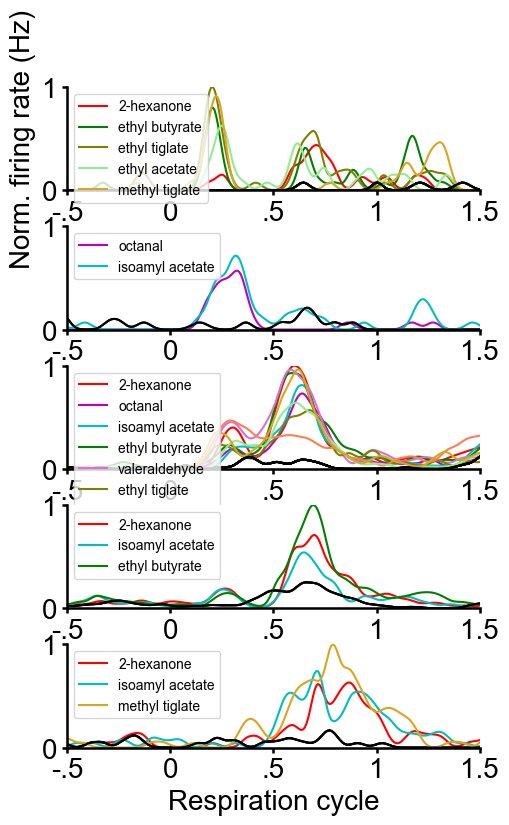

In [20]:
plt.figure(figsize = (10,10))
example_cells = [36,799,332,666,669]
odors = ['min oil', '2-hexanone', 'octanal', 'isoamyl acetate', 'ethyl butyrate', 'valeraldehyde', 'ethyl tiglate', 'acetophenone', 'ɣ-terpinine', 'ethyl acetate', 'methyl tiglate']
colors = ['k','r','m','c','g','orchid','olive', 'coral', 'lightblue', 'lightgreen', 'goldenrod']
analysis_window = np.where((x_warp>0)&(x_warp<6.28))[0]
for n_cells, cell in enumerate(example_cells):
    activating_odors = np.where(cells_activated[cell,:] == 1)[0]
    for odor in activating_odors:
        plt.subplot(6,1,n_cells+1)
        plt.plot(x_warp, phase_warped_PSTHs_expt_mean[cell,odor,:]/np.max(phase_warped_PSTHs_expt_mean[cell,:,analysis_window]), color = colors[odor], label = odors[odor])
        plt.plot(x_warp, phase_warped_PSTHs_expt_mean[cell,0,:]/np.max(phase_warped_PSTHs_expt_mean[cell,:,analysis_window]),'k')
        plt.legend(loc = 'upper left', fontsize = 10)
    plt.xlim(-6.28*.5, 6.28*1)
    if n_cells == 0:
        plt.ylabel('Norm. firing rate (Hz)')
    if n_cells == 4:
        plt.xlabel('Respiration cycle')
    plt.ylim(0,1)
    plt.xticks([-3.14,0,3.14,6.28,9.42], labels = ['-.5','0','.5','1','1.5'])
    PGanalysis.axis_fixer(ratio = .25, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\example_sequence_psths.pdf', bbox_inches = 'tight')

### For each of these cells, we will also plot the spontaneous phase preferences

In [28]:
shiva_data.keys()

dict_keys(['all_radius_low_expt', 'all_radius_high_expt', 'all_phase_hist_expt', 'spontaneous_phase_locked_expt', 'total_percent_spikes_exceeding_expt', 'resp_tuning_rate_expt', 'pre_post_inhalation_mat_expt', 'trial_type_inhalation_idxs_expt', 'spike_rasters_expt', 'time_aligned_PSTHs_expt', 'phase_aligned_rasters_expt', 'phase_warped_PSTHs_expt'])

In [29]:
# load the confidence intervals and true spontaneous spike-phase histograms for each cell
all_radius_low_cat = np.array([expt for expts in shiva_data['all_radius_low_expt'] for expt in expts])
all_radius_high_cat = np.array([expt for expts in shiva_data['all_radius_high_expt'] for expt in expts])
all_phase_hist_cat = np.array([expt for expts in shiva_data['all_phase_hist_expt'] for expt in expts])
all_resp_tuning_rate_cat = np.array([expt for expts in shiva_data['resp_tuning_rate_expt'] for expt in expts])

C:\Users\rmb55\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:6: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  
C:\Users\rmb55\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k" (-> color=(0.0, 0.0, 0.0, 1)). The keyword argument will take precedence.
  import sys
meta NOT subset; don't know how to subset; dropped


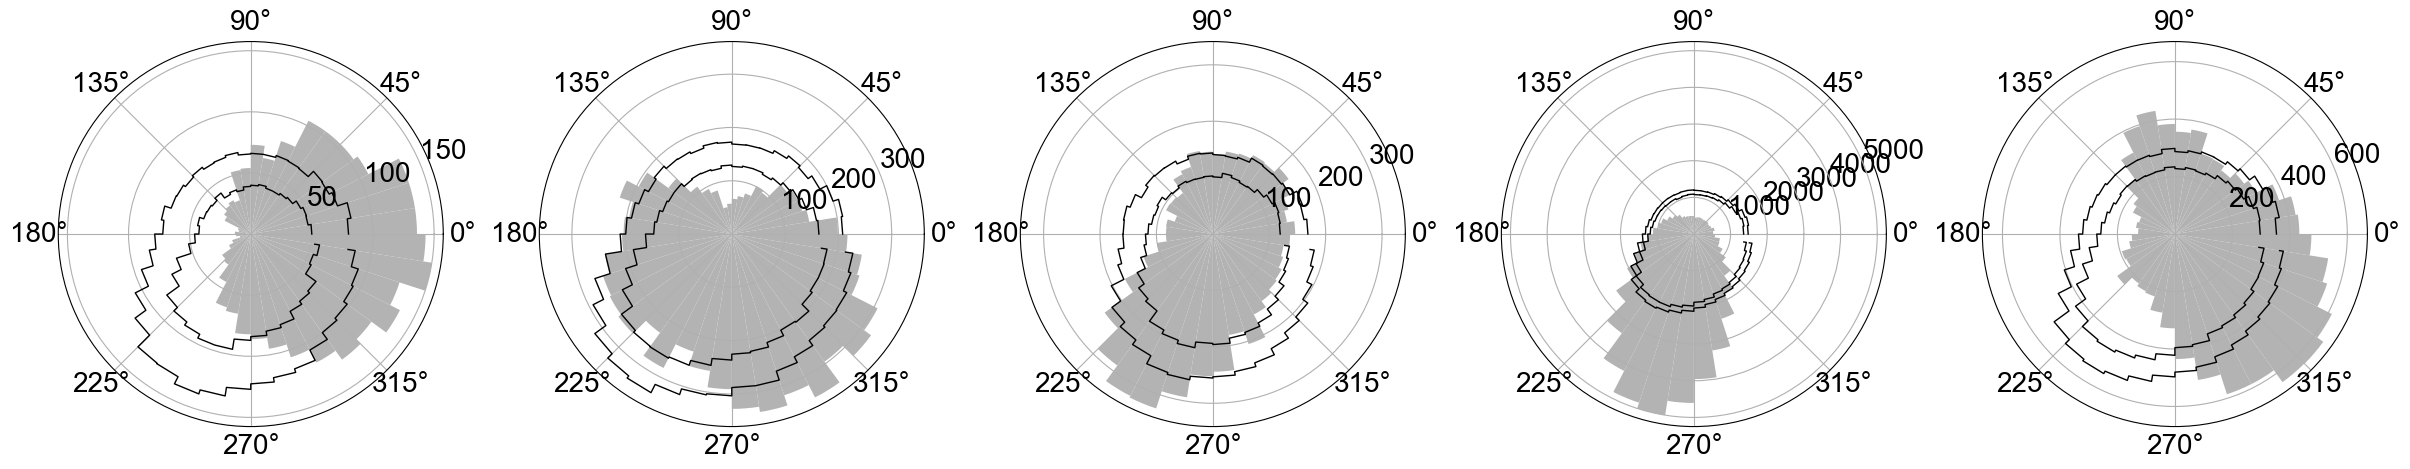

In [22]:
# plot confidence interval and true spike-phase histogram in phase-coordinates
bins = np.arange(0,np.radians(360)+np.radians(9), np.radians(9))
fig, ax = plt.subplots(1,5, subplot_kw=dict(projection='polar'), figsize = (30,5))
for cell_n, cell in enumerate(example_cells):
    ax[cell_n].bar(bins[:-1],all_phase_hist_cat[cell,:], align = 'edge', width = np.diff(bins), color = [.7,.7,.7])
    ax[cell_n].step(bins[:-1],all_radius_low_cat[cell,:], 'k', where="post",linewidth=1, color = 'k')
    ax[cell_n].step(bins[:-1],all_radius_high_cat[cell,:], 'k',where="post",linewidth=1, color = 'k')
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\example_cell_spontaneous_spikes.pdf', bbox_inches = 'tight')

### Now we will assess how similar a given cell's response is across all odors

### First, for each trial, calculate the mean phase of evoked spikes

In [23]:
# get the mean spike phase in the first breath for each trial 
mean_latency_first_breath = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(phase_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                spikes = []
                for spike in trial:
                    if ((spike > 0) & (spike <  np.radians(360))):
                        spikes.append(spike)
                mean_latency_first_breath[cell_counter, n_odor, n_trial] = scipy.stats.circmean(spikes) # if there are spikes, takes the circular mean, if not, results in nan
        cell_counter+=1

### Next, pull out the mean phase of spikes for significantly activating odors for each cell

In [24]:
# get the mean phase of spikes for each cell in response to each odor for significantly activated cells
trial_mean_n_spikes = np.zeros((n_total_cells,n_odors))+np.nan
trial_mean_latency = np.zeros((n_total_cells,n_odors))+np.nan
for cell_n, cell in enumerate(mean_latency_first_breath):
    for odor_n, odor in enumerate(cell):
        if sum(~np.isnan(odor))>0:
            # take the mean response phase across trials where there are spikes 
            trial_mean_latency[cell_n, odor_n] = scipy.stats.circmean(odor[~np.isnan(odor)])
            trial_mean_n_spikes[cell_n, odor_n]  = np.nanmean(spike_count_first_breath_cycle[cell_n,odor_n])
        else:
            trial_mean_latency[cell_n, odor_n] = np.nan
            trial_mean_n_spikes[cell_n, odor_n] = np.nan

In [25]:
# now for each cell, extract the response latencies only for significantly actvating odors. 
all_latencies = []
pref_latency = []
for cell_n, cell in enumerate(cells_activated):
    # get the latencies for significantly activating odors 
    latencies_activated_cells = trial_mean_latency[cell_n, np.where(cell>0)[0]]
    # get the number of spikes evoked by each significantly activating odor
    act_idx = np.where(cell>0)[0]
    spikes_act_idx = trial_mean_n_spikes[cell_n, act_idx]
    # if cell responds to more than one odor, append response latencies to nested list 
    if len(latencies_activated_cells)>1:
        # for each set of latencies, sort the latencies by the number of spikes evoked by each odor. In each array, the first element is the preferred odorant.
        all_latencies.append(latencies_activated_cells[np.flipud(np.argsort(spikes_act_idx))])

In [30]:
# calculate the mean latency for each cell 
mean_latencies = []
for cell in all_latencies:
    mean_latencies.append(scipy.stats.circmean(cell))
# sort the cells in ascending order by mean latency 
sort_order = np.flipud(np.argsort(mean_latencies))
pref_bins_spont = bins[np.argmax(all_resp_tuning_rate_cat,1)]

meta NOT subset; don't know how to subset; dropped


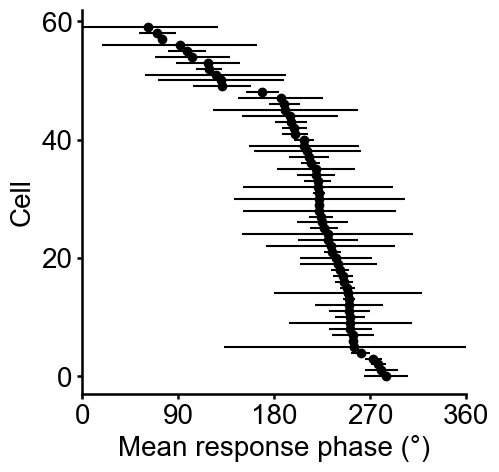

In [31]:
# plot the mean and standard deviation of response phase for all cells across significantly activating odors (for cells responsive to at least 3 odorants)
all_mean_latencies_sorted = []
all_cell_indices_sorted = []
all_latency_standard_deviations = []
cell_n = 0
for cell in sort_order:
    if len(all_latencies[cell])>2:
        plt.plot(scipy.stats.circmean(all_latencies[cell]), cell_n,'ko')
        plt.errorbar(scipy.stats.circmean(all_latencies[cell]), cell_n, xerr = scipy.stats.circstd(all_latencies[cell]), color = 'k')
        all_mean_latencies_sorted.append(all_latencies[cell])
        all_cell_indices_sorted.append(np.zeros(len(all_latencies[cell]))+cell_n)
        all_latency_standard_deviations.append(scipy.stats.circstd(all_latencies[cell]))
        cell_n+=1
plt.xlim(0,np.radians(360))
#plt.ylim(0,60)
plt.xticks([0,np.radians(90),np.radians(180),np.radians(270),np.radians(360)], labels = ['0','90','180','270','360'])
plt.ylabel('Cell')
plt.xlabel('Mean response phase (°)')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\response_phase_mean_std.pdf', bbox_inches = 'tight')

### Run a shuffled control to assess the distribution of standard deviations assuming cells respond to each odor at a random phase. 

In [32]:
n_iters = 1000
all_mean_latencies_sorted_flat = [latency for latencies in all_mean_latencies_sorted for latency in latencies]
bootstrapped_stds = np.empty(n_iters)
for iteration in range(n_iters):
    random.seed(iteration)
    new_shuffled_std = []
    random.shuffle(all_mean_latencies_sorted_flat)
    idx = 0
    for cell in all_mean_latencies_sorted:
        grab_n = len(cell)
        new_shuffled_std.append(scipy.stats.circstd(all_mean_latencies_sorted_flat[idx:idx+grab_n]))
        idx += grab_n
    bootstrapped_stds[iteration] = np.mean(np.degrees(new_shuffled_std))

meta NOT subset; don't know how to subset; dropped


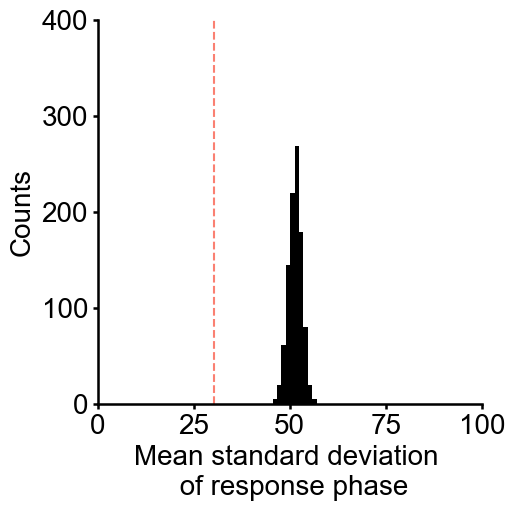

In [33]:
# plot a histogram of the mean standard deviations across 1000 iterations of randomly generated preferred phases
# additionally, plot the observed mean 
plt.hist(bootstrapped_stds, color = 'k')
plt.xlim(0,100)
plt.ylim(0,400)
std_mean_observed = np.degrees(np.mean(all_latency_standard_deviations))
plt.plot([std_mean_observed, std_mean_observed], [0,400], linestyle = '--', color = 'salmon')
plt.xlabel('Mean standard deviation \n of response phase')
plt.ylabel('Counts')
plt.xticks(np.arange(0,125,25))
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\bootstrapped_std_dist.pdf', bbox_inches = 'tight')

In [36]:
print('Observed mean standard deviation = ' + str(std_mean_observed))
CI = np.degrees(st.t.interval(alpha=0.95, df=len(all_latency_standard_deviations)-1, loc=np.mean(all_latency_standard_deviations), scale=st.sem(all_latency_standard_deviations)))
print('95% confidence interval = ' + str(np.mean(std_mean_observed) - CI[0]))

Observed mean standard deviation = 30.301424491327978
95% confidence interval = 6.763891646995685


In [38]:
print('mean std shuffled = ' + str(np.mean(bootstrapped_stds)))
CI = st.t.interval(alpha=0.95, df=len(bootstrapped_stds)-1, loc=np.mean(bootstrapped_stds), scale=st.sem(bootstrapped_stds)) 
print('95% confidence interval = ' + str(np.mean(bootstrapped_stds) - CI[0]))

mean std shuffled = 51.40345607862211
95% confidence interval = 0.1092377798480868


In [37]:
# The observed mean does not occur in the bootstrapped distribution. Therefore, we can say that p<.001
print('the observed mean occurs in the bootstrapped distribution ' + str(len(np.where(np.array(bootstrapped_stds)<std_mean_observed)[0])) + ' times')
print('from the bootstrapped analysis, p < .001')

the observed mean occurs in the bootstrapped distribution 0 times
from the bootstrapped analysis, p < .001


### As an additional metric, we will compute the PSTH consistency across odor pairs for the population. This is defined as the percentage of neurons for which self-self responses to two odors are more similar than self-other responses to the same odor pair

In [40]:
# Get the odor evoked PSTHs for the first two respiration cycles 
x_warp = np.arange(-60,60,.05)
analyze_resp = np.where((x_warp>0) & (x_warp<np.radians(360)*2))[0]
odor_phase_warped_psth_analyze = phase_warped_PSTHs_expt_cat[:,:,:,analyze_resp]
odor_phase_warped_psth_analyze_mean = np.mean(odor_phase_warped_psth_analyze,2)

In [41]:
# Get the spontaneous PSTHs for two respiration cycles prior to odor inhalation
analyze_indices_pre = np.where((x_warp>np.radians(360)*-9)&(x_warp<np.radians(360)*-7))[0][0:]
spontaneous_PSTHs = np.mean(phase_warped_PSTHs_expt_cat[:, :, :, analyze_indices_pre],(1,2))

In [42]:
# First, compute the PSTH consistency for all odor pairs
similarity_mats_odors = odor_phase_analysis.get_PSTH_consistency(cells_activated, odor_phase_warped_psth_analyze_mean)
odor_mean_distances = []
for mat in similarity_mats_odors:
    odor_mean_distances.append(np.nanmean(mat))

In [43]:
# Next, perform a shuffled control (shuffle cell identity) for all odor pairs
similarity_mats_shuff = odor_phase_analysis.get_PSTH_consistency_shuff(cells_activated, odor_phase_warped_psth_analyze_mean)
odor_mean_distances_shuff = []
for mat in similarity_mats_shuff:
    odor_mean_distances_shuff.append(np.nanmean(mat))

In [44]:
# Next, find the PSTH consistency between spontaneous and odor-evoked PSTHs
similarity_mats_spont = odor_phase_analysis.get_PSTH_consistency_spont(cells_activated, odor_phase_warped_psth_analyze_mean, spontaneous_PSTHs)
spont_mean_distances = []
for mat in similarity_mats_spont:
    spont_mean_distances.append(np.nanmean(mat))

In [45]:
# Finally, performa  shuffled control (shuffle cell identity) for all spontaneous-acivity to odor-evoked response comparisons
similarity_mats_spont_shuff = odor_phase_analysis.get_PSTH_consistency_spont_shuff(cells_activated, odor_phase_warped_psth_analyze_mean, spontaneous_PSTHs)
spont_mean_distances_shuff = []
for mat in similarity_mats_spont_shuff:
    spont_mean_distances_shuff.append(np.nanmean(mat))

meta NOT subset; don't know how to subset; dropped


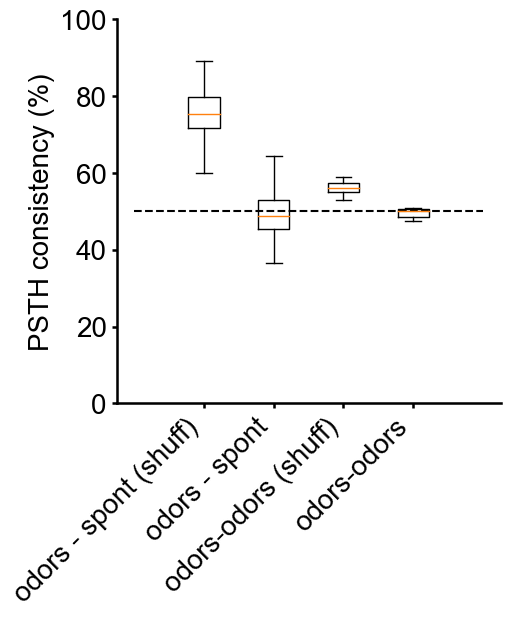

In [76]:
plt.boxplot([odor_mean_distances, odor_mean_distances_shuff, spont_mean_distances, spont_mean_distances_shuff], showfliers = False)
plt.ylim(0,1)
plt.plot([0,5],[.5,.5],'k--')
plt.ylabel('PSTH consistency (%)')
plt.xticks([1,2,3,4], ['odors - spont (shuff)', 'odors - spont', 'odors-odors (shuff)', 'odors-odors'], rotation = 45, ha = 'right')
plt.yticks([0,.2,.4,.6,.8,1], labels = ['0','20','40','60','80','100'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\psth_consistency_summary.pdf', bbox_inches = 'tight')

In [48]:
print('spont mean distance shuff = ' + str(np.mean(spont_mean_distances_shuff)))
CI = st.t.interval(alpha=0.95, df=len(spont_mean_distances_shuff)-1, loc=np.mean(spont_mean_distances_shuff), scale=st.sem(spont_mean_distances_shuff))
print('95% confidence interval = ' + str(np.mean(spont_mean_distances_shuff) - CI[0]))

spont mean distance shuff = 0.49954975469973883
95% confidence interval = 0.015750176183320586


In [49]:
print('spont mean distance = ' + str(np.mean(spont_mean_distances)))
CI = st.t.interval(alpha=0.95, df=len(spont_mean_distances)-1, loc=np.mean(spont_mean_distances), scale=st.sem(spont_mean_distances))
print('95% confidence interval = ' + str(np.mean(spont_mean_distances) - CI[0]))

spont mean distance = 0.5617774240225268
95% confidence interval = 0.013583205696977574


In [50]:
print('odor mean distance shuff = ' + str(np.mean(odor_mean_distances_shuff)))
CI = st.t.interval(alpha=0.95, df=len(odor_mean_distances_shuff)-1, loc=np.mean(odor_mean_distances_shuff), scale=st.sem(odor_mean_distances_shuff))
print('95% confidence interval = ' + str(np.mean(odor_mean_distances_shuff) - CI[0]))

odor mean distance shuff = 0.4918890121636745
95% confidence interval = 0.013066124505417498


In [51]:
print('odor mean distance = ' + str(np.mean(odor_mean_distances)))
CI = st.t.interval(alpha=0.95, df=len(odor_mean_distances)-1, loc=np.mean(odor_mean_distances), scale=st.sem(odor_mean_distances))
print('95% confidence interval = ' + str(np.mean(odor_mean_distances) - CI[0]))

odor mean distance = 0.7515514315171887
95% confidence interval = 0.013792383277013043


### Finally, we want to know if high consistency across odor stimuli can be explained by chemical similarity of the odorants, as opposed to the intrinsic properties of cells
### To test this, we will ask whether PSTH consistency increases as pairs of odorants become more similar. 
### We will compute the morgan similarity matrix for all odorants, and then assess the correlation between odor similarity and response consistency. 

In [52]:
# load the morgan similarity data
morgan_similarity_mat = np.load(r'Z:\robin\thesis\figures\chapter4\data\morgan_similarity_shiva.npy', allow_pickle = True)

meta NOT subset; don't know how to subset; dropped


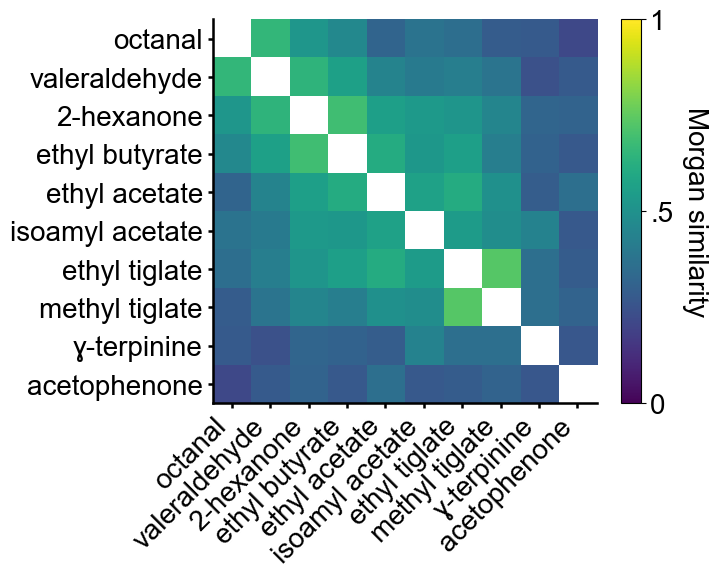

In [53]:
# Perform hierarchical clustering to visualize the odor similarity matrix
np.fill_diagonal(morgan_similarity_mat, 1)

df = pd.DataFrame(morgan_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])

# Perform hierarchical clustering
linkage_matrix = hierarchy.linkage(df, method='average', metric='euclidean', optimal_ordering = 1)

# Sort the correlation matrix based on the dendrogram
sorted_indices = hierarchy.leaves_list(linkage_matrix)

sorted_indices = hierarchy.leaves_list(linkage_matrix)
sorted_df = df.iloc[sorted_indices, sorted_indices]

sorted_odors = np.array(odors[1:])[sorted_indices.astype(int)]

sorted_morgan = sorted_df.to_numpy()
np.fill_diagonal(sorted_morgan, np.nan)
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

ax = plt.gca()
cbar = plt.colorbar(ticks = [0,.5,1])
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.5','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\morgan_similarity_matrix.pdf', bbox_inches = 'tight')

### Now, we will determine whether odorant structure predicts similarities in population response dynamics to these odors

In [54]:
all_similarity = []
for mat in similarity_mats_odors:
    # get the proportion of ones (dii<dij) in the similarity matrix. 
    # each matrix is size n_cells x n_cells that responded to the odor pair. For each pair of cells, if the distance between cell 1's response to odor 1 and odor 2 is less than the distance between cell 1's response to odor 1 and cell 2's response to odor 2, then the matrix contains a 1.
    # Here we calculate the percentage of pairs for which the similarity between odor 1 and 2 for a given cell is greater than the similarity between two different cell's responses to odor 1 and 2. 
    similarity = np.nanmean(mat)
    all_similarity.append(similarity)

In [55]:
# Reshape data into a matrix of average similarity metrics 
odor_similarity_mat = np.empty((len(sorted_odors),len(sorted_odors)))
counter = 0
for odor1 in range(len(sorted_odors)):
    for odor2 in range(len(sorted_odors)):
        if odor1 == odor2:
            odor_similarity_mat[odor1,odor2] = np.nan
        else:
            odor_similarity_mat[odor1,odor2] = all_similarity[counter]
            counter+=1

### Sort the PSTH consistency matrix by odor similarity

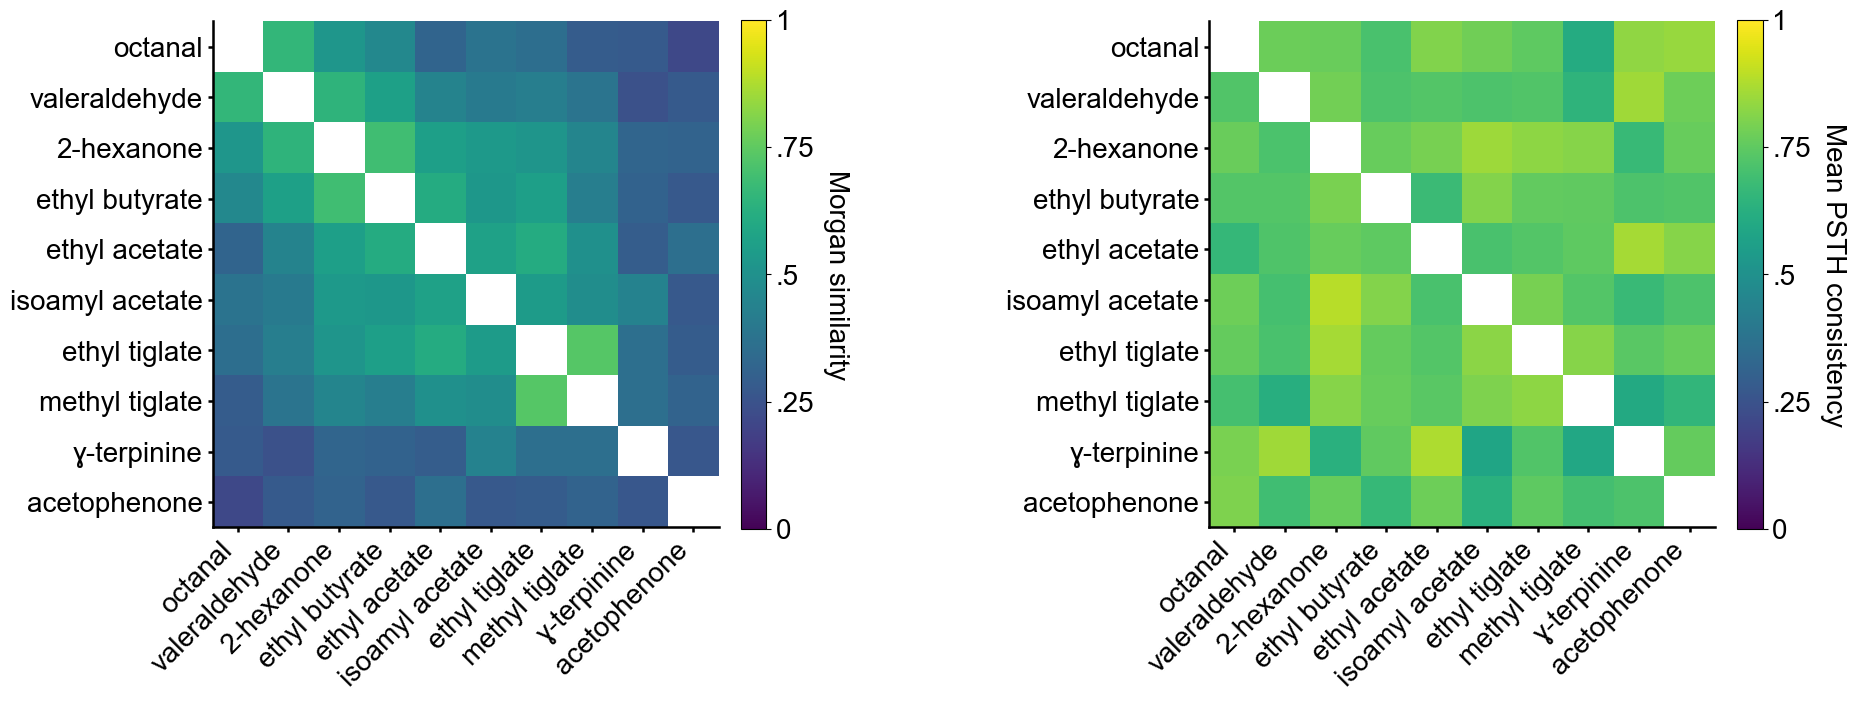

In [56]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
# use the indices of the sorted odors to plot the PSTH consistency matrix
odor_similarity_mat = pd.DataFrame(odor_similarity_mat, columns=[f'Item_{i+1}' for i in range(10)])
sorted_odor_similarity_mat = odor_similarity_mat.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_odor_similarity_mat)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)
ax = plt.gca()
cbar = plt.colorbar(fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Mean PSTH consistency', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.set_ticks([0,.25,.5,.75,1])
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

### Plot PSTH consistency vs. odor response similarity 

meta NOT subset; don't know how to subset; dropped


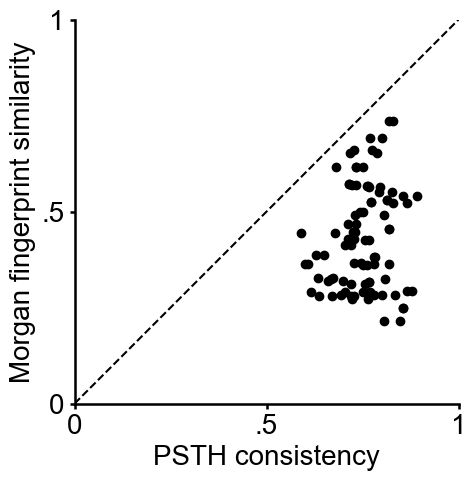

In [57]:
# now, plot the odor similarity vs consistency for each odor pair
sorted_morgan_similarity_ravel = np.ravel(sorted_morgan)
sorted_morgan_similarity_ravel = sorted_morgan_similarity_ravel[~np.isnan(sorted_morgan_similarity_ravel)]
sorted_odor_similarity_mat_ravel = np.ravel(sorted_odor_similarity_mat)
sorted_odor_similarity_mat_ravel = sorted_odor_similarity_mat_ravel[~np.isnan(sorted_odor_similarity_mat_ravel)]
plt.plot(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel,'ko')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('PSTH consistency')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\psth_consistency_odor_structure_correlation.pdf', bbox_inches = 'tight')

### PSTH consistency is not signficantly correlated with odorant structure (morgan similarity)

In [58]:
scipy.stats.pearsonr(sorted_odor_similarity_mat_ravel, sorted_morgan_similarity_ravel)

(0.14577588348519574, 0.17038876397741928)

### Finally, as a positive control, let's see whether the number of spikes fired by a given cell is determined by odor identity

### First, lets compute the z-scored population response correlation matrix

In [59]:
phase_aligned_rasters_expt = shiva_data['phase_aligned_rasters_expt']
n_total_cells = len(phase_aligned_rasters_cat)
n_odors = len(phase_aligned_rasters_cat[0])
n_trials = len(phase_aligned_rasters_cat[0][0])
### Initialize array to count the number of spikes occuring in the first respiration cycle for each trial
spike_count_first_breath_cycle = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(phase_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                n_spikes = 0
                for spike in trial:
                    # sum the number of spikes occuring in the first full cycle for each cell for each odor trial
                    if ((spike > 0) & (spike <  np.radians(360)*2)):
                        n_spikes+=1
                spike_count_first_breath_cycle[cell_counter, n_odor, n_trial] = n_spikes
        cell_counter+=1

In [60]:
phase_aligned_rasters_expt = shiva_data['phase_aligned_rasters_expt']
n_total_cells = len(phase_aligned_rasters_cat)
n_odors = len(phase_aligned_rasters_cat[0])
n_trials = len(phase_aligned_rasters_cat[0][0])
### Initialize array to count the number of spikes occuring in the first respiration cycle for each trial
spike_count_pre_breath_cycle = np.empty((n_total_cells, n_odors, n_trials))
cell_counter = 0
for n_expt, expt in enumerate(phase_aligned_rasters_expt):
    for cell in expt:
        for n_odor, odor in enumerate(cell):
            for n_trial, trial in enumerate(odor): 
                n_spikes = 0
                for spike in trial:
                    # sum the number of spikes occuring in the first full cycle for each cell for each odor trial
                    if ((spike > np.radians(360)*-2) & (spike <  0)):
                        n_spikes+=1
                spike_count_pre_breath_cycle[cell_counter, n_odor, n_trial] = n_spikes
        cell_counter+=1

In [61]:
# for each cell compute mean and standard deviation of pre-inhalation spikes:
spike_count_pre_breath_cycle_mean = np.mean(spike_count_pre_breath_cycle, (1,2))
spike_count_pre_breath_cycle_std = np.std(spike_count_pre_breath_cycle, (1,2))

### Compute the z-scored matrix using the distribution of pre-odor spikes

In [62]:
trial_mean_spike_counts = np.mean(spike_count_first_breath_cycle,2)

mean_spike_count_correlation_matrix = np.empty((n_odors-1, n_odors-1))
for odor_idx1, odor1 in enumerate(range(1,n_odors)):
    for odor_idx2, odor2 in enumerate(range(1,n_odors)):
            mean_spike_count_correlation_matrix[odor_idx1, odor_idx2] = np.corrcoef((trial_mean_spike_counts[:,odor1]-spike_count_pre_breath_cycle_mean)/spike_count_pre_breath_cycle_std, (trial_mean_spike_counts [:,odor2]-spike_count_pre_breath_cycle_mean)/spike_count_pre_breath_cycle_std)[0,1]

### Plot the odor structure and spike count correlation matrices sorted by odorant similarity

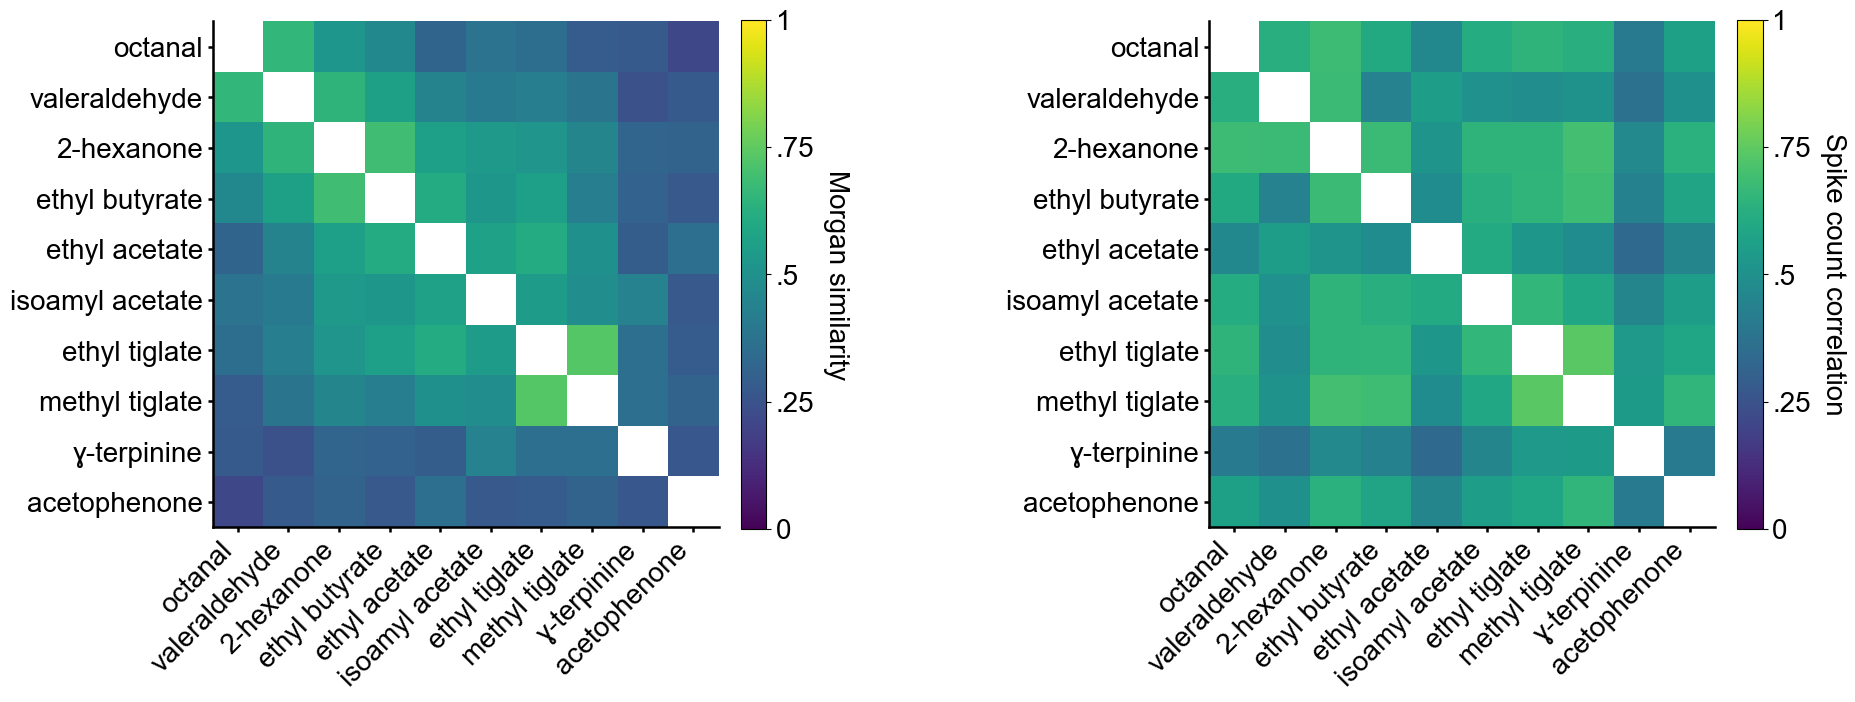

In [63]:
plt.figure(figsize = (20,20))

plt.subplot(1,2,1)
ax = plt.gca()
plt.imshow(sorted_morgan)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)


cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Morgan similarity', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

plt.subplot(1,2,2)
np.fill_diagonal(mean_spike_count_correlation_matrix, np.nan)
df = pd.DataFrame(mean_spike_count_correlation_matrix, columns=[f'Item_{i+1}' for i in range(10)])
sorted_spike_count_correlation_matrix = df.iloc[sorted_indices, sorted_indices]
plt.imshow(sorted_spike_count_correlation_matrix)
plt.clim(0,1)
plt.xticks(np.arange(10), labels = sorted_odors, rotation = 45, horizontalalignment = 'right')
plt.yticks(np.arange(10), labels = sorted_odors)

cbar = plt.colorbar(ticks = [0,.25,.5,.75,1],fraction=0.046, pad=0.04)
cbar.solids.set_edgecolor("face")
cbar.ax.set_ylabel('Spike count correlation', rotation = 270)
cbar.ax.get_yaxis().labelpad = 25
cbar.ax.set_yticklabels(['0','.25','.5','.75','1'])
PGanalysis.axis_fixer(ratio = 1, size = 20)

meta NOT subset; don't know how to subset; dropped


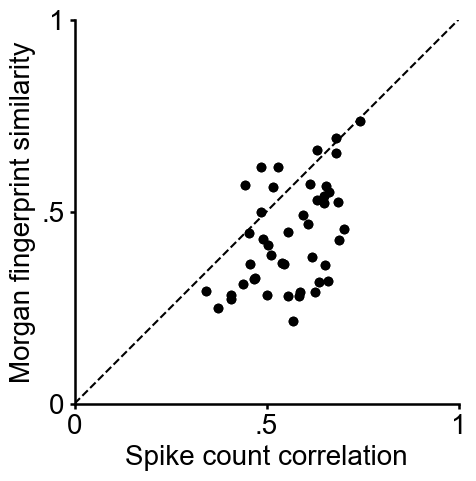

In [64]:
sorted_spike_count_correlation_ravel = np.ravel(sorted_spike_count_correlation_matrix)
sorted_spike_count_correlation_ravel = sorted_spike_count_correlation_ravel[~np.isnan(sorted_spike_count_correlation_ravel)]
plt.plot(sorted_spike_count_correlation_ravel, sorted_morgan_similarity_ravel,'ko')
plt.xlim(0,1)
plt.ylim(0,1)
plt.plot([0,1],[0,1],'k--')
plt.xticks([0,.5,1], ['0','.5','1'])
plt.yticks([0,.5,1], ['0','.5','1'])
plt.xlabel('Spike count correlation')
plt.ylabel('Morgan fingerprint similarity')
PGanalysis.axis_fixer(ratio = 1, size = 20)
plt.savefig(r'S:\All_Staff\robin\Paper\phase_coding_manuscript\figures\fig5\final\spike_count_odor_structure_correlation.pdf', bbox_inches = 'tight')

### Spike count correlations are signficantly correlated with odorant structure (morgan similarity)

In [65]:
scipy.stats.pearsonr(sorted_spike_count_correlation_ravel, sorted_morgan_similarity_ravel)

(0.4734653769662581, 2.4409267828617423e-06)